In [46]:
import numpy as np
import matplotlib.pyplot as plt
from read_hdf5 import read_hdf5_convolution

### Load data

['ant_temp', 'freq', 'lst']


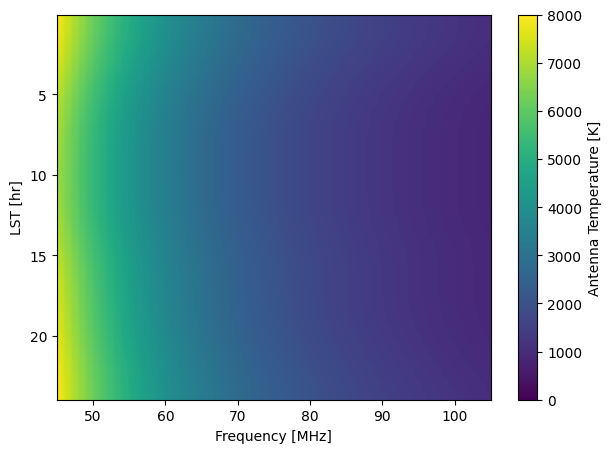

In [47]:
lst, freq, temp = read_hdf5_convolution(
    "simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5",
    print_key=True,
)
indx = (freq >= 45) * (freq <= 105)
freq = freq[indx]
temp = temp[:, indx]
nspec, nfreq = temp.shape
fg_mean = temp.mean(axis=0)  # avg spectrum, fg only

plt.figure(figsize=(7,5))
im = plt.imshow(
    temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

### Generate foreground model

(61, 6)


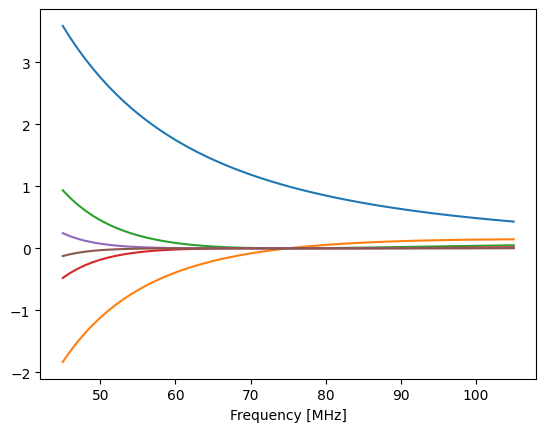

In [74]:
def design_mat(freq, nfg=5, beta=-2.5, nu_fg=75):
    """
    Generate a matrix of shape (Nfreq, Nfg) that evaluates the linlog model given a vector of foreground parameters.

    Parameters
    ----------
    freq : np.ndarray
        Frequencies to evaluate the model at.
    nfg : int
        Number of foreground terms.
    beta : float
        Spectral index of power law.
    nu_fg : float
        Normalization frequency in same units as freq.

    Returns
    -------
    A : np.ndarray
        The design matrix, i.e., a matrix with the linlog basis functions as the columns.
    
    """
    f_ratio = freq[:, None]/nu_fg  # dimensionless frequency ratio
    powers = np.arange(nfg)[None]
    A = f_ratio**beta * np.log(f_ratio)**powers
    return A

A = design_mat(freq, nfg=6)
print(A.shape)
nfg = A.shape[-1]

plt.figure()
for i in range(nfg_mean):
    plt.plot(freq, A[:, i])
plt.xlabel("Frequency [MHz]")
plt.show()

### Noise

The noise covariance is taken to be diagonal. We assume systematic uncertainities have been calibrated and are left with radiometer noise. The noise in each frequency channel scales according to the radiometer equation, that is, the satndard deviation is proportional to the system temperature.

The first paper took the noise for the 24h avg spectrum to be 3 mK at 75 MHz and we follow that here.

In [49]:
rng = np.random.default_rng(seed=1913)  # initialize random number generator
noise_75 = 3e-3
noise_std = noise_75 * fg_mean/fg_mean[freq==75]
noise_mean = rng.normal(scale=noise_std)

# add noise to fg
fg_mean += noise_mean

sigma = np.diag(noise_std**2)
sigma_inv = np.diag(1/noise_std**2)

### Global signal

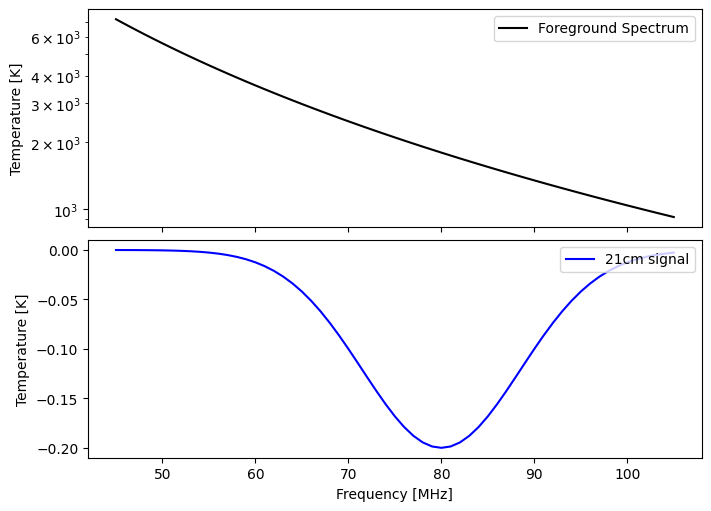

In [64]:
# injected global signal
def gauss(f, a=-0.2, w=20, nu21=80):
    """
    Gaussian in terms of frequency, amplitude, FWHM, and center freq. Default parameters are the ones used in Monsalve et al. 2023b.
    """
    if not np.isscalar(a):
        f = np.expand_dims(f, axis=1)
    return a * np.exp(-1/2 *((f-nu21) / w)**2 *8*np.log(2))

t21 = gauss(freq)
d = fg_mean + t21  # total spectrum

fig, axs = plt.subplots(figsize=(7,5), nrows=2, sharex=True, constrained_layout=True)
axs[0].semilogy(freq, fg_mean, label="Foreground Spectrum", c="k")
axs[1].plot(freq, t21, label="21cm signal", c="blue")
axs[1].set_xlabel("Frequency [MHz]")
for ax in axs:
    ax.legend(loc="upper right")
plt.setp(axs, ylabel="Temperature [K]")
plt.show()

In [90]:
# linearized global signals

# parameter bounds (a, w, nu21)
bounds = np.array([[-1., 0.], [1., 60.], [45., 105.]])
n_signals = 1000
signal_params = rng.uniform(size=(n_signals, len(bounds)), low=bounds.T[0], high=bounds.T[1])
signal_set = gauss(freq, *signal_params.T)

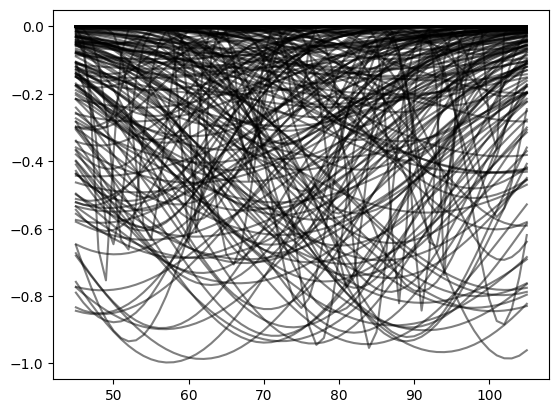

In [91]:
plt.figure()
plt.plot(freq, signal_set[:, ::5], color="k", alpha=0.5)
plt.show()

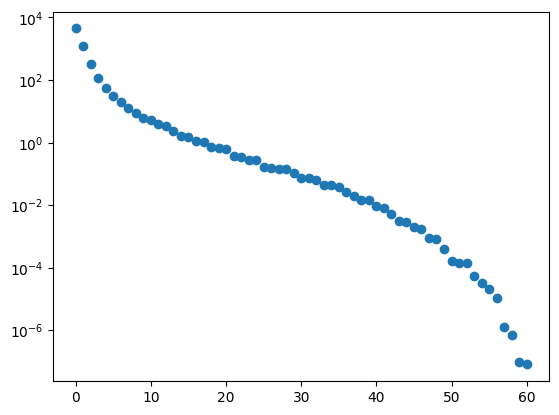

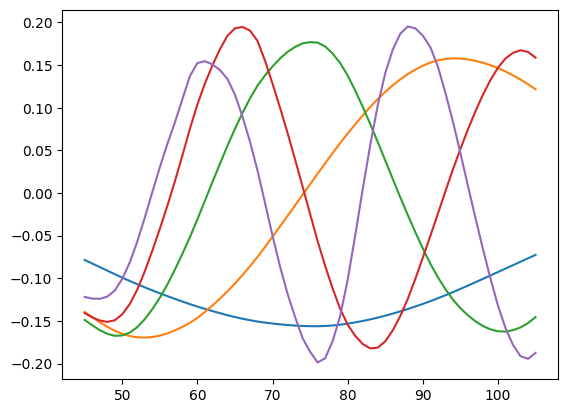

In [92]:
u, s, vt = np.linalg.svd(signal_set)  # cols of u are eigenvectors of the cov matrix
plt.figure()
plt.plot(s**2, marker="o", ls="none")  # eigenvalues
plt.yscale("log")
plt.show()

plt.figure()
for i in range(5):
    plt.plot(freq, u[:, i])
plt.show()

### Linear least squares

Using the foreground design matrix $\mathbf{A}$ and the signal eigenvectors $\mathbf{U}$, we can write a model for a data vector $\mathbf{d}$ as:
$$\mathbf{\hat{d}} = \mathbf{A} \mathbf{\theta_{\rm fg}} + \mathbf{U} \mathbf{\theta_{\rm 21}} = \mathbf{D} \mathbf{\theta},$$

where $\mathbf{D} \equiv \left[\mathbf{A}\; \mathbf{U} \right]$ and 
$\mathbf{\theta} \equiv \left[\mathbf{\theta_{\rm fg}}\; \mathbf{\theta_{\rm 21}}\right]^t$.

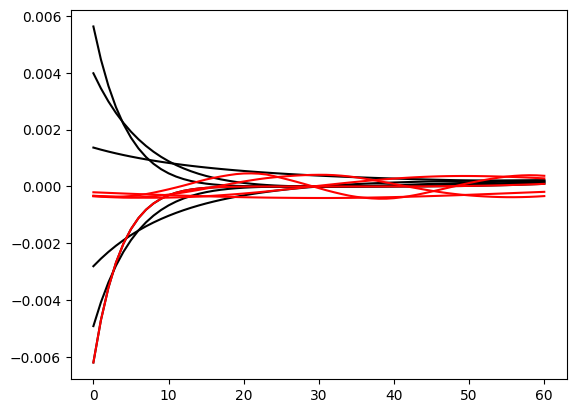

In [93]:
D = np.column_stack((A, u))
D /= np.sqrt(np.diag(D.T @ sigma_inv @ D))  # normalize modes
plt.figure()
for i in range(A.shape[1]):
    plt.plot(D[:, i], c="k")
for j in range(5):
    plt.plot(D[:, i+j], c="red")
plt.show()

The maximum likelihood estimator for $\mathbf{theta}$ is well known to be given as
$$\mathbf{\hat{\theta}} = \mathbf{C}\mathbf{D}^t\mathbf{\Sigma^{-1}} \mathbf{d},$$ 
$$\mathbf{C} = \left(\mathbf{D^t}\mathbf{\Sigma^{-1}}\mathbf{D}\right)^{-1},$$
where $\mathbf{\Sigma}$ is the noise covariance and $\mathbf{C}$ is the covariance of the MLE.

In [94]:
C = np.linalg.inv(D.T @ sigma_inv @ D)
theta_hat = C @ D.T @ sigma_inv @ d
dhat = D @ theta_hat

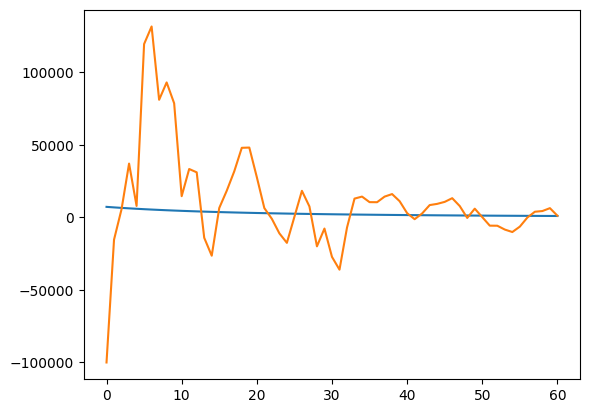

In [95]:
plt.figure()
plt.plot(d)
plt.plot(dhat)
plt.show()

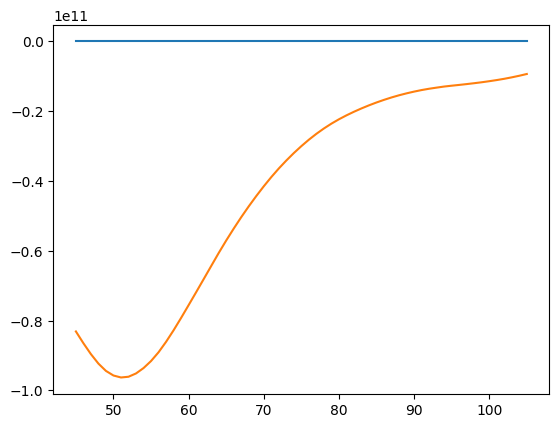

In [96]:
t21_hat = u @ theta_hat[nfg:]
plt.figure()
plt.plot(freq, t21)
plt.plot(freq, t21_hat)
plt.show()

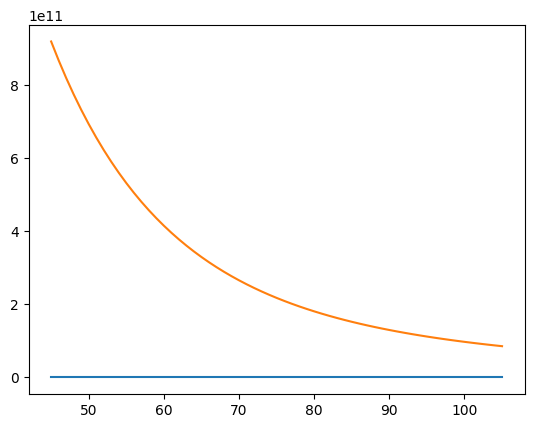

In [97]:
fg_hat = A @ theta_hat[:nfg]
plt.figure()
plt.plot(freq, fg_mean)
plt.plot(freq, fg_hat)
plt.show()